# TMDB 5000 EDA 

In [19]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

## Credits 
### Cast

In [2]:
credits = pd.read_csv("tmp/raw/tmdb_5000_credits.csv")

In [3]:
actor_counts = {}
actor_names = {}
# Iterate over each row in the DataFrame
for index, row in credits.iterrows():
    cast_list = json.loads(row['cast'])  # Parse the JSON cast list
    actors = [(entry['id'], entry['name']) for entry in cast_list]  # Extract actor names
    
    # Update actor counts dictionary
    for actor_id, actor_name in actors:
        actor_counts[actor_id] = actor_counts.get(actor_id, 0) + 1
        actor_names[actor_id] = actor_name


In [4]:
actor_movies = pd.DataFrame({'actor_id': list(actor_counts.keys()), 'movie_count': list(actor_counts.values())})
actor_movies['actor_name'] = actor_movies['actor_id'].apply(lambda x: actor_names[x])
actor_movies.sort_values(by='movie_count', ascending=False)

,actor_id,movie_count,actor_name
541,2231,67,Samuel L. Jackson
8260,380,57,Robert De Niro
5427,62,51,Bruce Willis
4008,1892,48,Matt Damon
205,192,46,Morgan Freeman
...,...,...,...
25047,12820,1,Belinda Mayne
25048,1220237,1,Todd Carty
25050,1747343,1,Bronco McLoughlin
25052,1747344,1,Gerard Naprous


In [5]:
actor_movies["movie_count"].value_counts(normalize=True).head(10)

1     0.713105
2     0.135396
3     0.053931
4     0.028413
5     0.015461
6     0.011083
7     0.007419
8     0.005697
9     0.005203
10    0.003810
Name: movie_count, dtype: float64

More than 70% of actors appear in only one movie in the dataset. We will limit our analysis to actors who have appeared in at least 2 movies. It will simplify our analysis and will also make it more relevant.

In [6]:
actors_multiple_films = [actor_id for actor_id, count in actor_counts.items() if count > 1]

In [7]:
credits['cast'] = credits['cast'].apply(lambda x: json.dumps([entry for entry in json.loads(x) if entry['id'] in actors_multiple_films]))

### Crew

In [8]:
crew_counts = {}
crew_names = {}
# Iterate over each row in the DataFrame
for index, row in credits.iterrows():
    crew_list = json.loads(row['crew'])  # Parse the JSON cast list
    crew_members = [(entry['id'], entry['name']) for entry in crew_list]  # Extract actor names
    
    # Update actor counts dictionary
    for person_id, person_name in crew_members:
        crew_counts[person_id] = crew_counts.get(person_id, 0) + 1
        crew_names[person_id] = person_name


In [9]:
crew_movies = pd.DataFrame({'person_id': list(crew_counts.keys()), 'movie_count': list(crew_counts.values())})
crew_movies['person_name'] = crew_movies['person_id'].apply(lambda x: crew_names[x])
crew_movies.sort_values(by='movie_count', ascending=False)

,person_id,movie_count,person_name
10955,2294,104,Robert Rodriguez
1210,488,84,Steven Spielberg
6578,2952,83,Avy Kaufman
3440,5914,82,Mary Vernieu
3519,3965,75,Deborah Aquila
...,...,...,...
30721,1720844,1,Phil Pham
30720,1720842,1,Curt Frisk
30719,1720840,1,Beth Ostermann
30718,1720839,1,Mario Dumont


In [10]:
crew_movies["movie_count"].value_counts(normalize=True).head(10)

1     0.589638
2     0.169367
3     0.077262
4     0.044228
5     0.029044
6     0.019646
7     0.013841
8     0.010646
9     0.009133
10    0.007261
Name: movie_count, dtype: float64

Almost 59% of crew members worked on only one movie in the dataset. Similarly to what we did for the cast, we will limit our analysis to crew members who have worked on at least 2 movies.

In [11]:
crew_multiple_films = [person_id for person_id, count in crew_counts.items() if count > 1]

In [12]:
credits['crew'] = credits['crew'].apply(lambda x: json.dumps([entry for entry in json.loads(x) if entry['id'] in crew_multiple_films]))

## Movies

In [13]:
movies = pd.read_csv("tmp/raw/tmdb_5000_movies.csv")

### Revenue 
Removing the movies with no revenue

In [14]:
(movies["revenue"] == 0).sum(), (movies["revenue"] == 0).mean()

(1427, 0.29710597543202166)

There are 1427 movies in the dataset with revenue equal to 0 (about 30% of all movies). We will remove them from the dataset as based on our research, these appear to be errors in the data or missing values are labeled as such. This also allows us to reduce the size of the data. 

In [15]:
movies_to_keep = [movie["id"] for i, movie in movies.iterrows() if movie["revenue"] > 0]
movies = movies[movies["id"].isin(movies_to_keep)].reset_index(drop=True)
credits = credits[credits["movie_id"].isin(movies_to_keep)].reset_index(drop=True)

As the distribution of revenue is highly skewed, we will use the log of revenue as our target variable. 

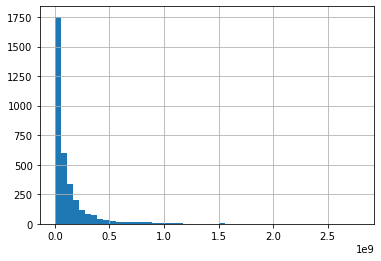

In [25]:
movies["revenue"].hist(bins=50)
plt.show()

<AxesSubplot:>

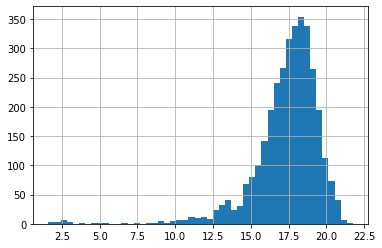

In [26]:
np.log(movies["revenue"]).hist(bins=50)

It can be seen that there are some movies with visibly lower revenue than the rest. We will remove these movies as they are likely to be outliers.

In [27]:
movies.sort_values(by="revenue", ascending=True)[["title", "revenue"]].head(30).style.format({"revenue": "${:,.0f}"})

,title,revenue
2731,Split Second,$5
3014,Dreaming of Joseph Lees,$7
2753,Bran Nue Dae,$7
2760,Bats,$10
2462,F.I.S.T.,$11
2586,Of Horses and Men,$11
1509,Chasing Liberty,$12
2148,The Cookout,$12
1721,Angela's Ashes,$13
1603,The 51st State,$14


In [32]:
(movies["revenue"] < 1_000_000).sum()

192

In [76]:
movies.sort_values(by = "popularity", ascending = True)[["title", "popularity"]].head(30)

,title,popularity
3051,Woman Thou Art Loosed,0.019984
3144,"The Book of Mormon Movie, Volume 1: The Journey",0.031947
2637,Limbo,0.034259
2487,There Goes My Baby,0.037073
3114,Mi America,0.039007
2794,Dolphins and Whales: Tribes of the Ocean,0.041651
3261,Fiza,0.043023
2753,Bran Nue Dae,0.050456
3331,Ayurveda: Art of Being,0.055868
2014,The Nutcracker,0.068228


In [33]:
(movies["popularity"] < 1).sum()

72

Moreover, there are also 72 movies with popularity less than 1. We will also remove them from the dataset as well.

In [34]:
movies_to_keep = [movie["id"] for i, movie in movies.iterrows() if movie["revenue"] >= 1_000_000 and movie["popularity"] >= 1]

In [35]:
movies = movies[movies["id"].isin(movies_to_keep)].reset_index(drop=True)

In [36]:
credits = credits[credits["movie_id"].isin(movies_to_keep)].reset_index(drop=True)

### Feature engineering

In [37]:
columns_to_drop = ["homepage", "original_title", "status"]
movies = movies.drop(columns_to_drop, axis=1)

In [38]:
movies["is_english"] = movies["original_language"].apply(lambda x: int(x == "en"))
movies.drop("original_language", axis=1, inplace=True)

In [39]:
movies["release_year"] = movies["release_date"].str.slice(0, 4).astype(int)
movies["release_month"] = movies["release_date"].str.slice(5, 7).astype(int)
movies.drop("release_date", axis=1, inplace=True)

Potential features to extract: 
- one hot encoding for genres
- one hot encoding for production companies
- one hot encoding for languages 

We can select only the most popular ones.

#### genres

In [40]:
genre_counts = {}
for row in movies["genres"]:
    genres = json.loads(row)
    for genre in genres:
        genre_name = genre['name']
        genre_counts[genre_name] = genre_counts.get(genre_name, 0) + 1

In [41]:
genre_counts

{'Action': 906,
 'Adventure': 657,
 'Fantasy': 339,
 'Science Fiction': 416,
 'Crime': 506,
 'Drama': 1388,
 'Thriller': 909,
 'Animation': 183,
 'Family': 368,
 'Western': 55,
 'Comedy': 1105,
 'Romance': 560,
 'Horror': 321,
 'Mystery': 256,
 'History': 140,
 'War': 109,
 'Music': 108,
 'Documentary': 31,
 'Foreign': 1}

In [42]:
def check_genre(genres_list, specific_genre):
    for genre in genres_list:
        if genre["name"] == specific_genre:
            return True
    return False

# add one hot encoded genre columns
for genre in genre_counts.keys():
    if genre == "Foreign":
         pass
    else: 
        movies[genre] = movies["genres"].apply(lambda x: check_genre(json.loads(x), genre)).astype(int)

#### languages

In [43]:
spoken_languages = {}
for row in movies["spoken_languages"]:
    languages = json.loads(row)
    for lan in languages:
        lan_iso = lan['iso_639_1']
        spoken_languages[lan_iso] = spoken_languages.get(lan_iso, 0) + 1

In [44]:
pd.DataFrame({"iso": list(spoken_languages.keys()), "count": list(spoken_languages.values())}).sort_values(by="count", ascending=False).head(10)

,iso,count
0,en,3055
2,fr,298
1,es,266
4,de,174
10,ru,149
3,it,140
7,zh,79
13,ja,78
20,ar,55
16,pt,49


In [45]:
languages_to_keep = ["fr", "es", "de", "ru", "it", "ja", "zh"]

In [46]:
def check_language(languages_list, specific_language):
    for language in languages_list:
        if language["iso_639_1"] == specific_language:
            return True
    return False

# add one hot encoded language columns
for language in languages_to_keep:
    movies[language] = movies["spoken_languages"].apply(lambda x: check_language(json.loads(x), language)).astype(int)

#### production companies

In [47]:
production_companies = {}
for row in movies["production_companies"]:
    companies = json.loads(row)
    for c in companies:
        c_name = c['name']
        production_companies[c_name] = production_companies.get(c_name, 0) + 1

In [48]:
pd.DataFrame({'company': list(production_companies.keys()), 'count': list(production_companies.values())}).sort_values(by='count', ascending=False).head(20)

,company,count
11,Warner Bros.,282
52,Universal Pictures,270
38,Paramount Pictures,246
1,Twentieth Century Fox Film Corporation,203
7,Columbia Pictures,168
46,New Line Cinema,143
54,Relativity Media,100
4,Walt Disney Pictures,99
193,Touchstone Pictures,92
49,Metro-Goldwyn-Mayer (MGM),89


In [49]:
production_companies_to_keep = ["Warner Bros.", "Universal Pictures", "Paramount Pictures", "Twentieth Century Fox Film Corporation", "Columbia Pictures", "New Line Cinema", "Walt Disney Pictures", "Relativity Media"]

In [50]:
def check_company(companies_list, specific_company):
    for company in companies_list:
        if company["name"] == specific_company:
            return True
    return False

# add one hot encoded company columns
for company in production_companies_to_keep:
    movies[company] = movies["production_companies"].apply(lambda x: check_company(json.loads(x), company)).astype(int)

#### overview

In [66]:
import spacy
import tqdm
nlp = spacy.load('en_core_web_lg')

In [67]:
tqdm.tqdm.pandas()
movies["overview"] = movies["overview"].progress_apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

100%|██████████| 3145/3145 [00:38<00:00, 81.87it/s]


In [68]:
credits.to_csv("tmp/raw/tmdb_5000_credits_processed.csv", index=False)
movies.to_csv("tmp/raw/tmdb_5000_movies_processed.csv", index=False)